In [ ]:
import os
import re
from urllib.request import Request, urlopen
from urllib.error import URLError, HTTPError
from bs4 import BeautifulSoup
import html5lib
import matplotlib.pyplot as plt 

Retrieve the raw html from the artist page on Metrolyrics.com 

In [ ]:
def retrieve_html(url):
  hdr = {'User-Agent': 'Mozilla/5.0'}
  req = Request(url, headers=hdr)            #{'User-Agent': 'Mozilla/5.0'}
  try:
    stream = urlopen(req)
    html = stream.read()
    stream.close()
    html = html.decode('utf-8')
    soup = BeautifulSoup(html, 'html5lib')
    return soup
  except HTTPError as e:
    print('The server couldn\'t fulfill the request.')
    print('Error code: ', e.code)
  except URLError as e:
    print('We failed to reach a server.')
    print('Reason: ', e.reason)

The HTML contains hyperlinks to pages which contain the lyrics for each song. The following function gets the URLs to the lyrics for all the songs by a given artist.

In [ ]:
def get_song_urls(artist_name):
  name = artist_name.lower()
  url_name = re.sub(' ', '-', name)
  url = 'https://www.metrolyrics.com/' + url_name + '-lyrics.html'
  soup = retrieve_html(url)
  song_htmls = []
  song_titles = []
  for tag in soup.find_all('a', alt = True):
    song_htmls.append(tag['href'])
    title = tag['alt'].lower()
    T = re.match(name, title)
    if T:
      title = title[len(name):] # remove artist name from beginning of song title
    title = title[:-6] # remove 'lyrics' from end of song title
    song_titles.append(title.strip(' -'))
  return song_htmls, song_titles

Pull the lyrics from the URL that has song lyrics

In [ ]:
def get_lyrics(song_url):
  lyrics = ''
  html = retrieve_html(song_url)
  for t in html.find_all('p', {'class':'verse'}):
    lyrics += t.getText() + '\n' # there will be empty new line at end
  return lyrics

In [ ]:
def get_lyrics_corpus(artist_name):
  song_urls, song_titles = get_song_urls(artist_name)
  lyrics = []
  for i in range(len(song_urls)):
    lyrics.append(get_lyrics(song_urls[i]))
  return lyrics, song_titles

In [ ]:
artists = ['Chevelle', 'Thrice', 'Finch', 'Saosin']

In [ ]:
lyrics, song_titles = [], []
for artist in artists:
  l, t = get_lyrics_corpus(artist)
  lyrics += l
  song_titles += t

In [ ]:
def get_lines(lyrics): # generate list containing all lines from all songs
  all_lines = []
  for i in range(len(lyrics)):
    lines = lyrics[i].split('\n')[:-1]
    for line in lines:
      if line != '':
        all_lines.append(line.strip())
  return all_lines

In [ ]:
lines = get_lines(lyrics)

In [ ]:
def get_songs(lyrics): # list where each entry contains all lyrics to a single song
  songs = []
  for i in range(len(lyrics)):
    lines = lyrics[i].split('\n')[:-1]
    song = ''
    for line in lines:
      if line != '':
        song += line.strip() + ' '
    songs.append(song.strip())
  return songs

In [ ]:
songs = get_songs(lyrics)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GRU, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(lines)

In [ ]:
word_index = dict([(val, key) for key, val in tokenizer.word_index.items()])

n_words = len(word_index)

In [ ]:
tokenized_lines = tokenizer.texts_to_sequences(lines)

for i, line in enumerate(tokenized_lines):
  if len(line) < 2:
    del tokenized_lines[i]

Build a model which is trained on n-grams of the lines from the songs

In [ ]:
def generate_n_grams(tokenized_lines):
  n_grams = []
  for i in range(len(tokenized_lines)):
    line = tokenized_lines[i]
    for i in range(1,len(line)):
      n_grams.append(line[:i+1])
  max_len = max([len(x) for x in n_grams])
  return pad_sequences(n_grams, maxlen = max_len, padding = 'pre'), max_len

In [ ]:
train_lines, max_len = generate_n_grams(tokenized_lines)

In [ ]:
inputs, labels = train_lines[: , :-1], tf.keras.utils.to_categorical(train_lines[:, -1], num_classes = n_words+1)

In [ ]:
tf.keras.backend.clear_session()

model = Sequential([ #n_words + 1 for the padding character
                    Embedding(n_words+1, 30, input_length = max_len - 1), # max_len - 1 since we remove last word of sequence
                    Bidirectional(LSTM(128, return_sequences = True)),
                    Bidirectional(LSTM(128)),
                    Dense(n_words+1, activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 26, 30)            123690    
_________________________________________________________________
bidirectional (Bidirectional (None, 26, 256)           162816    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 4123)              1059611   
Total params: 1,740,357
Trainable params: 1,740,357
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x = inputs, y =labels, epochs = 50)

Epoch 1/50
1453/1453 [==============================] - 25s 12ms/step - loss: 6.5983 - accuracy: 0.0435
Epoch 2/50
1453/1453 [==============================] - 18s 13ms/step - loss: 5.8277 - accuracy: 0.0656
Epoch 3/50
1453/1453 [==============================] - 18s 13ms/step - loss: 5.4480 - accuracy: 0.0952
Epoch 4/50
1453/1453 [==============================] - 19s 13ms/step - loss: 5.1971 - accuracy: 0.1101
Epoch 5/50
1453/1453 [==============================] - 19s 13ms/step - loss: 4.9429 - accuracy: 0.1287
Epoch 6/50
1453/1453 [==============================] - 19s 13ms/step - loss: 4.7462 - accuracy: 0.1449
Epoch 7/50
1453/1453 [==============================] - 19s 13ms/step - loss: 4.5300 - accuracy: 0.1576
Epoch 8/50
1453/1453 [==============================] - 19s 13ms/step - loss: 4.3669 - accuracy: 0.1739
Epoch 9/50
1453/1453 [==============================] - 19s 13ms/step - loss: 4.2052 - accuracy: 0.1904
Epoch 10/50
1453/1453 [==============================] - 19s 13m

In [ ]:
def plot_training_metrics(history, metric):
  met = history.history[metric]

  plt.plot(met, label=metric)
  plt.xlabel('Epochs')
  plt.show()
  plt.close()

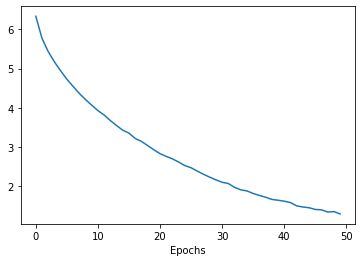

In [ ]:
plot_training_metrics(history, 'loss')

In [ ]:
def preprocess_text(text):
  tokens = tokenizer.texts_to_sequences([text])
  return pad_sequences(tokens, maxlen = max_len - 1, padding = 'pre')

In [ ]:
def predict_next_word(model, seed_text, temp = 0.1):
  seed = preprocess_text([seed_text])
  probas = model.predict(seed)
  rescaled_logits = tf.math.log(probas) / temp
  word_id = tf.random.categorical(rescaled_logits, num_samples=1)
  return word_index[int(word_id.numpy())]

In [ ]:
def generate_lyrics(model, seed_text, num = 20, temp = 0.1):
  lyric = seed_text
  for i in range(num):
    next_word = predict_next_word(model, lyric, temp = temp)
    lyric += ' ' + next_word
  return lyric

In [ ]:
generate_lyrics(model, 'Is it worth it can you even hear me', temp = 2)

"Is it worth it can you even hear me she's have nothing's nobody have i chance an wait dead upon be was learned if siren try we i night"

Build a model trained windowed portions of the song lyrics (use the previous 10 words in the song to predict the next)

In [ ]:
tokenized_songs = tokenizer.texts_to_sequences(songs)

In [ ]:
def window_dataset(dataset, n_words, seq_len):
  window_length = seq_len + 1 # use n=seq_len characters to predict the last character
  windows = dataset.window(size=window_length, shift=1, drop_remainder=True)
  windows = windows.flat_map(lambda w: w.batch(window_length))
  return windows

In [ ]:
def get_windowed_songs(tokenized_songs, n_words, seq_len, batch_size = 128, shuff_buff = 10000):
  windowed_songs = []
  for s in tokenized_songs:
    windows = window_dataset(tf.data.Dataset.from_tensor_slices(s), n_words, seq_len)
    for window in windows:
      windowed_songs.append(window.numpy())
  D = tf.data.Dataset.from_tensor_slices(np.array(windowed_songs) - 1)
  D = D.shuffle(shuff_buff)
  D = D.map(lambda w: (w[:-1], tf.one_hot(w[-1], depth = n_words)))
  D = D.batch(batch_size)
  # data = data.prefetch(1)
  return D

In [ ]:
train_data = get_windowed_songs(tokenized_songs, n_words, 10) # use previous 10 words to predict next word

In [ ]:
tf.keras.backend.clear_session()

win_model = Sequential([
                    Embedding(n_words, 30, input_length = None), 
                    Bidirectional(LSTM(128, return_sequences = True)),
                    Bidirectional(LSTM(128)),
                    Dense(n_words, activation = 'softmax')
])

win_model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')

win_model.summary()

win_history = win_model.fit(train_data, epochs = 50)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 30)          123660    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         162816    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 4122)              1059354   
Total params: 1,740,070
Trainable params: 1,740,070
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
419/419 [==============================] - 10s 12ms/step - loss: 6.7970 - accuracy: 0.0467
Epoch 2/50
419/419 [==============================] - 5s 12ms/step - loss: 6.1982 - accuracy: 0.0482
Epoch 3/50
419/419 [=====================

In [ ]:
def lyric_gen(model, seed_text, num = 10, temp = 1):
  words = seed_text.lower().split()
  word_collection = list(word_index.values())
  n_ooc = 0
  for word in words:
    if word not in word_collection:
      print('{} not in corpus; please input different word'.format(word))
      n_ooc += 1
  if n_ooc > 0:
    return
  lyric = seed_text
  for i in range(num):
    tokens = tokenizer.texts_to_sequences([lyric])
    tokens = np.array(tokens)-1
    probas = model.predict(np.expand_dims(tokens, axis = -1))
    rescaled_logits = tf.math.log(probas) / temp
    word_id = tf.random.categorical(rescaled_logits, num_samples=1)
    next_word = word_index[int(word_id.numpy())+1]
    lyric += ' ' + next_word
  return lyric


In [ ]:
lyric_gen(win_model,'Is it worth it can you even hear me', temp = 1)

"Is it worth it can you even hear me i won't abandon to run away it's far but when"

In [ ]:
tf.keras.backend.clear_session()

conv_model = Sequential([
                    tf.keras.layers.Conv1D(filters=32, kernel_size = 5, strides = 1, padding = 'causal', input_shape = [None,1], activation = 'relu'), 
                    Bidirectional(LSTM(128, return_sequences = True)),
                    Bidirectional(LSTM(128)),
                    Dense(n_words, activation = 'softmax')
])

conv_model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')

conv_model.summary()

conv_history = win_model.fit(train_data, epochs = 30)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         164864    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 4122)              1059354   
Total params: 1,618,650
Trainable params: 1,618,650
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
419/419 [==============================] - 5s 12ms/step - loss: 0.4705 - accuracy: 0.9066
Epoch 2/30
419/419 [==============================] - 5s 12ms/step - loss: 0.4376 - accuracy: 0.9148
Epoch 3/30
419/419 [======================

In [ ]:
lyric_gen(conv_model,'Is it worth it can you even hear me', temp = 1)

'Is it worth it can you even hear me refusing rhyme ship drew clouds weather men mean blink half'